In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Introduction
---
This project is about looking into the most significant variables for detecting a heart failure.

# Data Introduction
---
This data is from Kaggle: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data
It contains 12 features:
- 7 qualitative
- 5 quantitative

The target variable is `HeartDisease`:
- 1 means that observation has detected a heart disease
- 0 means that there is no heart disease

We are interested in these variables, with descriptions according to Kaggle Data Card:
- Age: I'm assuming the older someone is, the more likely they'll have a heart disease.
- Sex: Male or female
- ChestPainType: There are 4 different type's of chest pain in this dataset:
  - TA: Typical Angina -
  - ATA: Atypical Angina -
  - NAP: Non-Anginal Pain -
  - ASY: Asymptomatic -
- RestBP: High resting BP might be a sign of a possible heart attack.
- Cholesterol: A cholesterol above a certain threshold might cause a heart attack.
- FastingBS: Fasting blood sugar:
  - 1: if FastingBS > 120
  - 0: Otherwise
- RestingECG: 3 different levels
  - Normal
  - ST: having ST-T wave abnormality (depression)
  - LVH: showing probable or definite left ventricular hypertrophy
- MaxHR: Maximum heart rate achieved
- ExerciseAngina: Exercise-induced angina with 2 outcomes
  - Yes
  - No
- Oldpeak: ST - numeric value measured in depression
- ST_Slope: slope of peak exercise ST segment
  - Up: upsloping
  - Flat: flat
  - Down: downsloping

In [77]:
# import libraries
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [78]:
# import data with polars
path = "/content/drive/MyDrive/Data/heart.xls"
df = pl.read_csv(path)
df.head()

Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
i64,str,str,i64,i64,i64,str,i64,str,f64,str,i64
40,"""M""","""ATA""",140,289,0,"""Normal""",172,"""N""",0.0,"""Up""",0
49,"""F""","""NAP""",160,180,0,"""Normal""",156,"""N""",1.0,"""Flat""",1
37,"""M""","""ATA""",130,283,0,"""ST""",98,"""N""",0.0,"""Up""",0
48,"""F""","""ASY""",138,214,0,"""Normal""",108,"""Y""",1.5,"""Flat""",1
54,"""M""","""NAP""",150,195,0,"""Normal""",122,"""N""",0.0,"""Up""",0


In [79]:
df["RestingECG"].value_counts()

RestingECG,count
str,u32
"""LVH""",188
"""Normal""",552
"""ST""",178


# Data Information
---

In [80]:
df.glimpse()

Rows: 918
Columns: 12
$ Age            <i64> 40, 49, 37, 48, 54, 39, 45, 54, 37, 48
$ Sex            <str> 'M', 'F', 'M', 'F', 'M', 'M', 'F', 'M', 'M', 'F'
$ ChestPainType  <str> 'ATA', 'NAP', 'ATA', 'ASY', 'NAP', 'NAP', 'ATA', 'ATA', 'ASY', 'ATA'
$ RestingBP      <i64> 140, 160, 130, 138, 150, 120, 130, 110, 140, 120
$ Cholesterol    <i64> 289, 180, 283, 214, 195, 339, 237, 208, 207, 284
$ FastingBS      <i64> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ RestingECG     <str> 'Normal', 'Normal', 'ST', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal'
$ MaxHR          <i64> 172, 156, 98, 108, 122, 170, 170, 142, 130, 120
$ ExerciseAngina <str> 'N', 'N', 'N', 'Y', 'N', 'N', 'N', 'N', 'Y', 'N'
$ Oldpeak        <f64> 0.0, 1.0, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 1.5, 0.0
$ ST_Slope       <str> 'Up', 'Flat', 'Up', 'Flat', 'Up', 'Up', 'Up', 'Up', 'Flat', 'Up'
$ HeartDisease   <i64> 0, 1, 0, 1, 0, 0, 0, 0, 1, 0



In [81]:
df.describe()

statistic,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
str,f64,str,str,f64,f64,f64,str,f64,str,f64,str,f64
"""count""",918.0,"""918""","""918""",918.0,918.0,918.0,"""918""",918.0,"""918""",918.0,"""918""",918.0
"""null_count""",0.0,"""0""","""0""",0.0,0.0,0.0,"""0""",0.0,"""0""",0.0,"""0""",0.0
"""mean""",53.510893,null,null,132.396514,198.799564,0.233115,null,136.809368,null,0.887364,null,0.553377
"""std""",9.432617,null,null,18.514154,109.384145,0.423046,null,25.460334,null,1.06657,null,0.497414
"""min""",28.0,"""F""","""ASY""",0.0,0.0,0.0,"""LVH""",60.0,"""N""",-2.6,"""Down""",0.0
"""25%""",47.0,null,null,120.0,173.0,0.0,null,120.0,null,0.0,null,0.0
"""50%""",54.0,null,null,130.0,223.0,0.0,null,138.0,null,0.6,null,1.0
"""75%""",60.0,null,null,140.0,267.0,0.0,null,156.0,null,1.5,null,1.0
"""max""",77.0,"""M""","""TA""",200.0,603.0,1.0,"""ST""",202.0,"""Y""",6.2,"""Up""",1.0


In [82]:
df.null_count()

Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0


# Data Visualization
---
We want to check if there is a class imbalance with countplots. We also want to check the numerical features and see if there's any outliers. I also want to just split the categorical features and the numerical features, so that it's easier to work. I'm also going to turn `Age`, `RestingBP`, `Cholesterol`, and, `MaxHR` to Float's and keep the integer types as integers because they are encoded categorical variables.

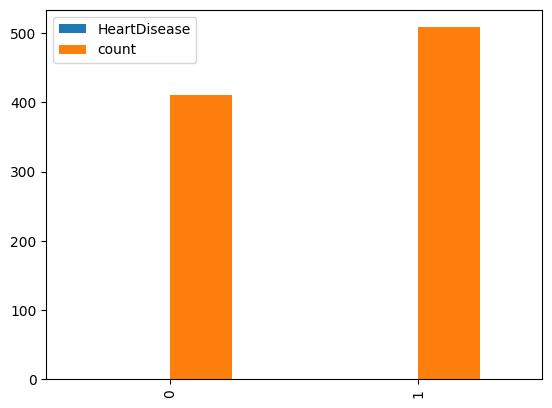

In [83]:
# class imbalance
df["HeartDisease"].value_counts().to_pandas().plot(kind="bar")
plt.show()

- So there is a bit of a class imbalance, and we wil use SMOTE later for "over-sampling" so the classes can be equal.

In [84]:
# convert Age, RestingBP, Cholesterol, and MaxHR to floats and qualitative strings and ints to categorical
df = df.with_columns(
    pl.col("Age").cast(pl.Float64),
    pl.col("RestingBP").cast(pl.Float64),
    pl.col("Cholesterol").cast(pl.Float64),
    pl.col("MaxHR").cast(pl.Float64),
    pl.col("FastingBS").cast(pl.Utf8).cast(pl.Categorical),
    pl.col("Sex").cast(pl.Utf8).cast(pl.Categorical),
    pl.col("ChestPainType").cast(pl.Utf8).cast(pl.Categorical),
    pl.col("RestingECG").cast(pl.Utf8).cast(pl.Categorical),
    pl.col("ExerciseAngina").cast(pl.Utf8).cast(pl.Categorical),
    pl.col("ST_Slope").cast(pl.Utf8).cast(pl.Categorical),
    pl.col("HeartDisease").cast(pl.Utf8).cast(pl.Categorical)
)
df.glimpse()

Rows: 918
Columns: 12
$ Age            <f64> 40.0, 49.0, 37.0, 48.0, 54.0, 39.0, 45.0, 54.0, 37.0, 48.0
$ Sex            <cat> M, F, M, F, M, M, F, M, M, F
$ ChestPainType  <cat> ATA, NAP, ATA, ASY, NAP, NAP, ATA, ATA, ASY, ATA
$ RestingBP      <f64> 140.0, 160.0, 130.0, 138.0, 150.0, 120.0, 130.0, 110.0, 140.0, 120.0
$ Cholesterol    <f64> 289.0, 180.0, 283.0, 214.0, 195.0, 339.0, 237.0, 208.0, 207.0, 284.0
$ FastingBS      <cat> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ RestingECG     <cat> Normal, Normal, ST, Normal, Normal, Normal, Normal, Normal, Normal, Normal
$ MaxHR          <f64> 172.0, 156.0, 98.0, 108.0, 122.0, 170.0, 170.0, 142.0, 130.0, 120.0
$ ExerciseAngina <cat> N, N, N, Y, N, N, N, N, Y, N
$ Oldpeak        <f64> 0.0, 1.0, 0.0, 1.5, 0.0, 0.0, 0.0, 0.0, 1.5, 0.0
$ ST_Slope       <cat> Up, Flat, Up, Flat, Up, Up, Up, Up, Flat, Up
$ HeartDisease   <cat> 0, 1, 0, 1, 0, 0, 0, 0, 1, 0



In [86]:
num_vars = df.select([col for col in df.columns if df[col].dtype == pl.Float64])
cat_vars = df.select([col for col in df.columns if df[col].dtype == pl.Categorical ])
num_vars, cat_vars

(shape: (918, 5)
 ┌──────┬───────────┬─────────────┬───────┬─────────┐
 │ Age  ┆ RestingBP ┆ Cholesterol ┆ MaxHR ┆ Oldpeak │
 │ ---  ┆ ---       ┆ ---         ┆ ---   ┆ ---     │
 │ f64  ┆ f64       ┆ f64         ┆ f64   ┆ f64     │
 ╞══════╪═══════════╪═════════════╪═══════╪═════════╡
 │ 40.0 ┆ 140.0     ┆ 289.0       ┆ 172.0 ┆ 0.0     │
 │ 49.0 ┆ 160.0     ┆ 180.0       ┆ 156.0 ┆ 1.0     │
 │ 37.0 ┆ 130.0     ┆ 283.0       ┆ 98.0  ┆ 0.0     │
 │ 48.0 ┆ 138.0     ┆ 214.0       ┆ 108.0 ┆ 1.5     │
 │ 54.0 ┆ 150.0     ┆ 195.0       ┆ 122.0 ┆ 0.0     │
 │ …    ┆ …         ┆ …           ┆ …     ┆ …       │
 │ 45.0 ┆ 110.0     ┆ 264.0       ┆ 132.0 ┆ 1.2     │
 │ 68.0 ┆ 144.0     ┆ 193.0       ┆ 141.0 ┆ 3.4     │
 │ 57.0 ┆ 130.0     ┆ 131.0       ┆ 115.0 ┆ 1.2     │
 │ 57.0 ┆ 130.0     ┆ 236.0       ┆ 174.0 ┆ 0.0     │
 │ 38.0 ┆ 138.0     ┆ 175.0       ┆ 173.0 ┆ 0.0     │
 └──────┴───────────┴─────────────┴───────┴─────────┘,
 shape: (918, 7)
 ┌─────┬───────────────┬───────────┬───────────

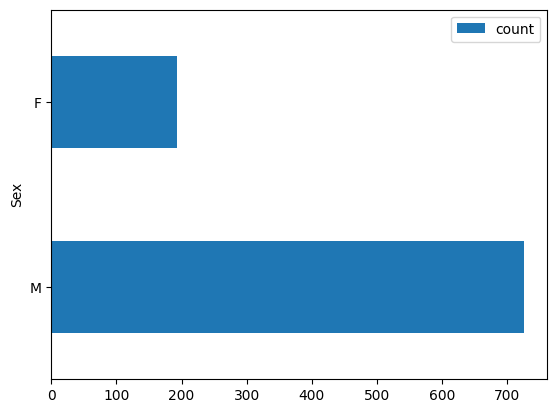

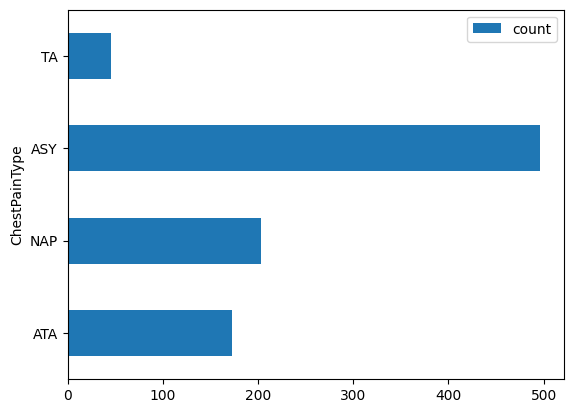

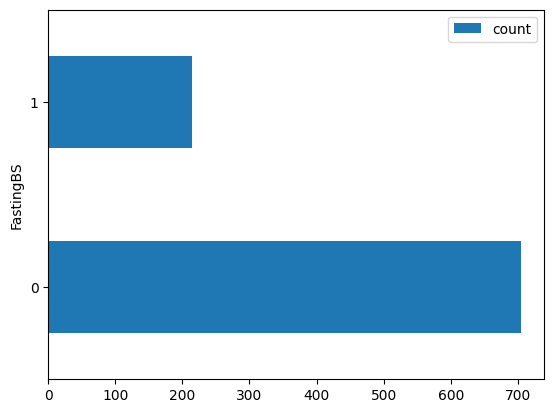

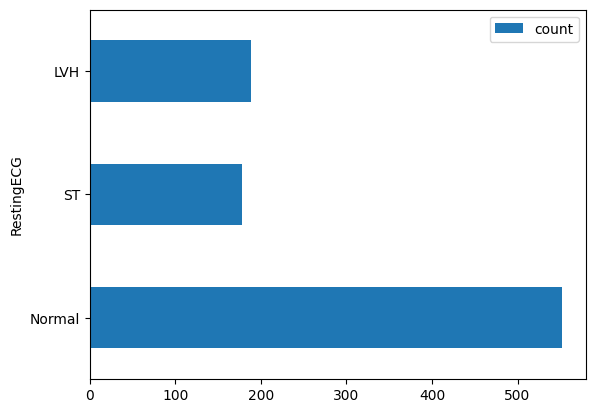

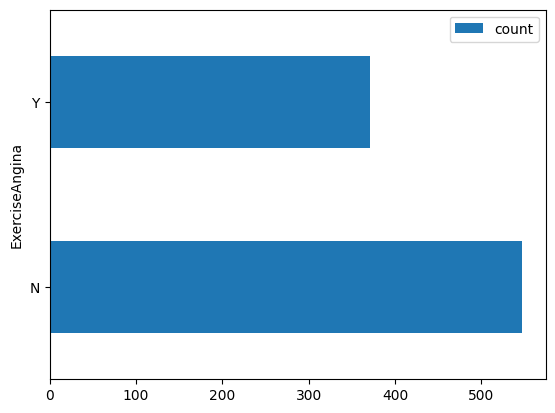

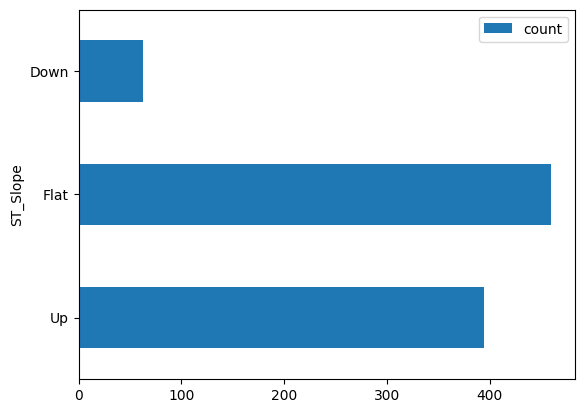

In [96]:
for col in cat_vars.columns:
  if col != "HeartDisease":
    df[col].value_counts().to_pandas().plot(kind='barh', x=col, y="count")
    plt.ylabel(col)
    plt.show()

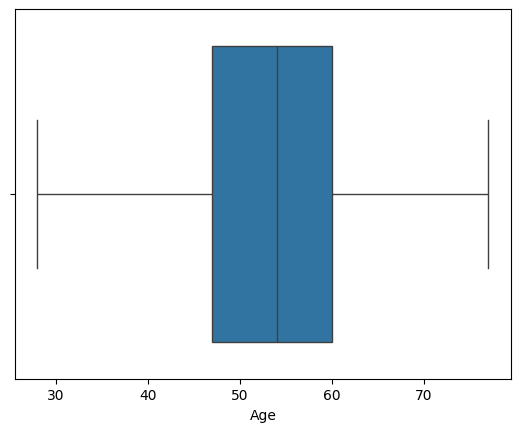

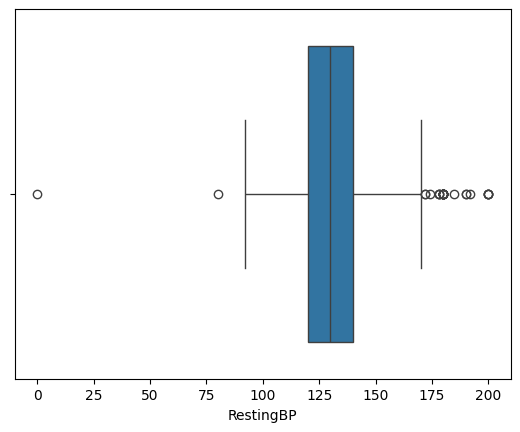

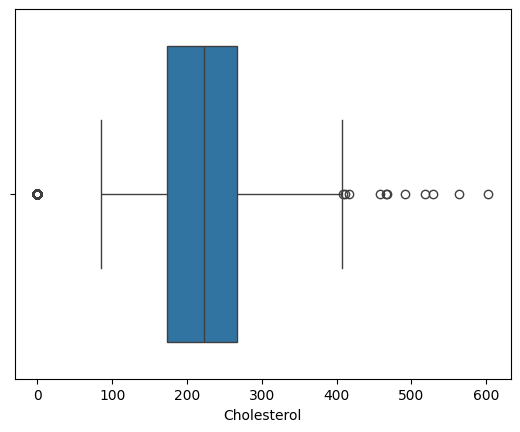

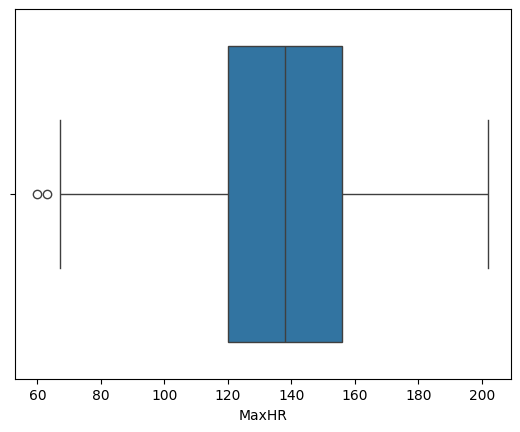

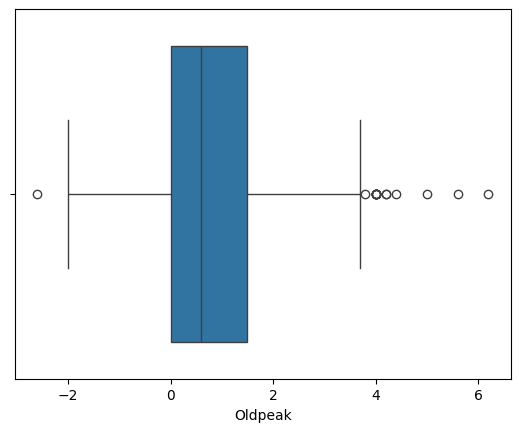

In [101]:
for col in num_vars:
  sns.boxplot(data=df, x=col)
  plt.show()

Let's see what the outliers look like using IQR threshold method. I think we should keep in mind that outliers for variables like cholesterol might serve a purpose. Really high cholesterol is surely going to cause some problems that need to be looked at. Also, if we look, there is a Resting BP at basically 0, which is probably not very good. It looks like we will remove the outliers that are on the left side/below the lower bound.  

In [125]:
# IQR threshold method
def outlier_iqr(df, col):
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  filter_series = pl.Series(df.select([pl.col(col).is_between(lower_bound, upper_bound)]))
  return filter_series

In [136]:
for col in num_vars.columns:
  print(outlier_iqr(df, col).value_counts())

shape: (1, 2)
┌──────┬───────┐
│ Age  ┆ count │
│ ---  ┆ ---   │
│ bool ┆ u32   │
╞══════╪═══════╡
│ true ┆ 918   │
└──────┴───────┘
shape: (2, 2)
┌───────────┬───────┐
│ RestingBP ┆ count │
│ ---       ┆ ---   │
│ bool      ┆ u32   │
╞═══════════╪═══════╡
│ true      ┆ 890   │
│ false     ┆ 28    │
└───────────┴───────┘
shape: (2, 2)
┌─────────────┬───────┐
│ Cholesterol ┆ count │
│ ---         ┆ ---   │
│ bool        ┆ u32   │
╞═════════════╪═══════╡
│ true        ┆ 735   │
│ false       ┆ 183   │
└─────────────┴───────┘
shape: (2, 2)
┌───────┬───────┐
│ MaxHR ┆ count │
│ ---   ┆ ---   │
│ bool  ┆ u32   │
╞═══════╪═══════╡
│ false ┆ 2     │
│ true  ┆ 916   │
└───────┴───────┘
shape: (2, 2)
┌─────────┬───────┐
│ Oldpeak ┆ count │
│ ---     ┆ ---   │
│ bool    ┆ u32   │
╞═════════╪═══════╡
│ false   ┆ 16    │
│ true    ┆ 902   │
└─────────┴───────┘


In [ ]:
# make function that removes lower bound outliers

In [ ]:
# remove the outliers below the lower bound but keep the upper bound outliers
for col in num_vars.columns:
  df = df.filter(outlier_iqr(df, col))
  print(df.select([pl.col(col)]).describe())

# Preprocessing Data
---
The first thing we will do is drop Customer ID because it provides no value to the dataset, and will not help with predictions/modeling.

In [97]:
# get dummy variables and drop the first dummy variable of each variable group because the other variables in each variable group will be 0
df_dummies = pl.concat([df.select(num_vars), df.select(cat_vars).to_dummies(drop_first=True)], how="horizontal")

In [98]:
df_dummies.head()

Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_F,ChestPainType_ASY,ChestPainType_NAP,ChestPainType_TA,FastingBS_1,RestingECG_LVH,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,HeartDisease_1
f64,f64,f64,f64,f64,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
40.0,140.0,289.0,172.0,0.0,0,0,0,0,0,0,0,0,0,0,0
49.0,160.0,180.0,156.0,1.0,1,0,1,0,0,0,0,0,0,1,1
37.0,130.0,283.0,98.0,0.0,0,0,0,0,0,0,1,0,0,0,0
48.0,138.0,214.0,108.0,1.5,1,1,0,0,0,0,0,1,0,1,1
54.0,150.0,195.0,122.0,0.0,0,0,1,0,0,0,0,0,0,0,0


In [137]:
# create features and target variable
X = df_dummies.drop("HeartDisease_1")
y = df_dummies["HeartDisease_1"]

In [138]:
# split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [140]:
# fix imbalancing
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.to_numpy(), y_train.to_numpy())

In [148]:
pl.Series(y_train_resampled).value_counts(), y_train_resampled.shape

(shape: (2, 2)
 ┌─────┬───────┐
 │     ┆ count │
 │ --- ┆ ---   │
 │ u8  ┆ u32   │
 ╞═════╪═══════╡
 │ 1   ┆ 401   │
 │ 0   ┆ 401   │
 └─────┴───────┘,
 (802,))

In [147]:
X_train_resampled.shape

(802, 15)

# Modeling
---
We will use Logistic Regression, LightGBM, XGBoost, and KNN. We will compare the metrics on each and then build a final model afterwards. The optuna library will be used to tune hyperparameters.

In [150]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 4.1 MB/s eta 0:00:00


In [152]:
import optuna
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [153]:
models = {
    "Logistic Regression": LogisticRegression(),
    "LightGBM": LGBMClassifier(),
    "XGBoost": XGBClassifier(),
    "KNN": KNeighborsClassifier()
}

In [165]:
# create objective function for optuna
def objective(trial, model_name):
    if model_name == "Logistic Regression":
        # Define hyperparameters to tune for Logistic Regression
        logreg_c = trial.suggest_float("C", 1e-5, 1e5, log=True)
        logreg_solver = trial.suggest_categorical("solver", ["liblinear", "lbfgs"])
        model = LogisticRegression(C=logreg_c, solver=logreg_solver, random_state=42)

    elif model_name == "LightGBM":
        # Define hyperparameters to tune for LightGBM
        lgbm_n_estimators = trial.suggest_int("n_estimators", 50, 1000)
        lgbm_learning_rate = trial.suggest_float("learning_rate", 1e-5, 0.1, log=True)
        lgbm_num_leaves = trial.suggest_int("num_leaves", 2, 256)
        lgbm_max_depth = trial.suggest_int("max_depth", -1, 50)
        lgbm_min_child_samples = trial.suggest_int("min_child_samples", 5, 100)
        model = LGBMClassifier(n_estimators=lgbm_n_estimators, learning_rate=lgbm_learning_rate,
                               num_leaves=lgbm_num_leaves, max_depth=lgbm_max_depth,
                               min_child_samples=lgbm_min_child_samples, random_state=42)

    elif model_name == "XGBoost":
        # Define hyperparameters to tune for XGBoost
        xgb_n_estimators = trial.suggest_int("n_estimators", 50, 1000)
        xgb_learning_rate = trial.suggest_float("learning_rate", 1e-5, 0.1, log=True)
        xgb_max_depth = trial.suggest_int("max_depth", 3, 10)
        xgb_min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
        xgb_gamma = trial.suggest_float("gamma", 0, 1.0)
        xgb_subsample = trial.suggest_float("subsample", 0.6, 1.0)
        xgb_colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
        model = XGBClassifier(n_estimators=xgb_n_estimators, learning_rate=xgb_learning_rate,
                              max_depth=xgb_max_depth, min_child_weight=xgb_min_child_weight,
                              gamma=xgb_gamma, subsample=xgb_subsample,
                              colsample_bytree=xgb_colsample_bytree, random_state=42)

    elif model_name == "KNN":
        # Define hyperparameters to tune for KNN
        knn_n_neighbors = trial.suggest_int("n_neighbors", 1, 30)
        knn_weights = trial.suggest_categorical("weights", ["uniform", "distance"])
        knn_metric = trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski"])
        model = KNeighborsClassifier(n_neighbors=knn_n_neighbors, weights=knn_weights, metric=knn_metric)

    else:
        raise ValueError(f"Model '{model_name}' not supported.")

    # Train the model
    model.fit(X_train_resampled, y_train_resampled)

    # Evaluate the model on the test set
    # Convert X_test to numpy array for prediction consistency
    y_pred = model.predict(X_test.to_numpy())
    roc_auc = roc_auc_score(y_test, y_pred)

    return roc_auc

In [166]:
# create studys
study_logreg = optuna.create_study(direction="maximize")
study_lgbm = optuna.create_study(direction="maximize")
study_xgb = optuna.create_study(direction="maximize")
study_knn = optuna.create_study(direction="maximize")

[I 2025-09-25 23:14:24,065] A new study created in memory with name: no-name-e78b2075-6118-4187-bc4d-633eaabc612e
[I 2025-09-25 23:14:24,067] A new study created in memory with name: no-name-d44ff6d6-06fa-4603-86dc-1fe7f4bf9103
[I 2025-09-25 23:14:24,069] A new study created in memory with name: no-name-e1a30d41-125c-4250-8e71-b1261fe4cc30
[I 2025-09-25 23:14:24,072] A new study created in memory with name: no-name-78c8f2f1-8b48-42be-9c5f-65a8a35e17d4


In [169]:
# create study dictionary for looping
studies = {
    "Logistic Regression": study_logreg,
    # "LightGBM": study_lgbm,
    "XGBoost": study_xgb,
    "KNN": study_knn
}

In [170]:
results = []

for model_name, study in studies.items():
    print(f"Running Optuna study for {model_name}...")
    study.optimize(lambda trial: objective(trial, model_name), n_trials=50) # You can adjust the number of trials
    best_params = study.best_params
    best_roc_auc = study.best_value

    # Train the best model and evaluate on test set to get other metrics
    if model_name == "Logistic Regression":
        best_model = LogisticRegression(**best_params, random_state=42)
    elif model_name == "LightGBM":
        best_model = LGBMClassifier(**best_params, random_state=42)
    elif model_name == "XGBoost":
        best_model = XGBClassifier(**best_params, random_state=42)
    elif model_name == "KNN":
        best_model = KNeighborsClassifier(**best_params)
    else:
        best_model = None # Should not happen with the current models

    if best_model:
        best_model.fit(X_train_resampled, y_train_resampled)
        y_pred = best_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)

        results.append({
            "Model": model_name,
            "Best Params": best_params,
            "ROC AUC": best_roc_auc,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "Confusion Matrix": conf_matrix.tolist() # Convert to list for easier storage/display
        })

results_df = pl.DataFrame(results)
display(results_df)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2025-09-25 23:15:20,934] Trial 50 finished with value: 0.8481004976332078 and parameters: {'C': 0.1399390951285397, 'solver': 'lbfgs'}. Best is trial 4 with value: 0.8667920864182546.


Running Optuna study for Logistic Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2025-09-25 23:15:21,062] Trial 51 finished with value: 0.8667920864182546 and parameters: {'C': 1245.8015400334616, 'solver': 'lbfgs'}. Best is trial 4 with value: 0.8667920864182546.
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/

Running Optuna study for XGBoost...


[I 2025-09-25 23:15:27,009] Trial 0 finished with value: 0.8696443743172715 and parameters: {'n_estimators': 736, 'learning_rate': 0.028052201519303818, 'max_depth': 7, 'min_child_weight': 7, 'gamma': 0.36462088791191527, 'subsample': 0.8097353442879975, 'colsample_bytree': 0.9001379952857984}. Best is trial 0 with value: 0.8696443743172715.
[I 2025-09-25 23:15:27,305] Trial 1 finished with value: 0.8714649836145163 and parameters: {'n_estimators': 805, 'learning_rate': 0.015071690575138, 'max_depth': 7, 'min_child_weight': 9, 'gamma': 0.2527414282689876, 'subsample': 0.7044589245699557, 'colsample_bytree': 0.6718653095401954}. Best is trial 1 with value: 0.8714649836145163.
[I 2025-09-25 23:15:27,479] Trial 2 finished with value: 0.876137880810778 and parameters: {'n_estimators': 430, 'learning_rate': 0.006781671751641335, 'max_depth': 4, 'min_child_weight': 10, 'gamma': 0.6018286554487982, 'subsample': 0.8199580248899381, 'colsample_bytree': 0.6185771170618716}. Best is trial 2 with 

Running Optuna study for KNN...


[I 2025-09-25 23:15:45,142] Trial 14 finished with value: 0.6943803859691711 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: 0.722417769146741.
[I 2025-09-25 23:15:45,159] Trial 15 finished with value: 0.6915280980701541 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: 0.722417769146741.
[I 2025-09-25 23:15:45,174] Trial 16 finished with value: 0.6478941619128534 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 0 with value: 0.722417769146741.
[I 2025-09-25 23:15:45,189] Trial 17 finished with value: 0.6943803859691711 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: 0.722417769146741.
[I 2025-09-25 23:15:45,207] Trial 18 finished with value: 0.7167131933487074 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial

Model,Best Params,ROC AUC,Accuracy,Precision,Recall,F1 Score,Confusion Matrix
str,struct[12],f64,f64,f64,f64,f64,list[list[i64]]
"""Logistic Regression""","{null,null,null,null,null,null,null,8895.658442,""lbfgs"",null,null,null}",0.871465,0.869565,0.910891,0.859813,0.884615,"[[68, 9], [15, 92]]"
"""XGBoost""","{643,0.009868,6,2,0.893745,0.727295,0.974085,null,null,null,null,null}",0.901323,0.902174,0.92381,0.906542,0.915094,"[[69, 8], [10, 97]]"
"""KNN""","{null,null,null,null,null,null,null,null,null,7,""distance"",""manhattan""}",0.734373,0.722826,0.825581,0.663551,0.735751,"[[62, 15], [36, 71]]"


# Evaluation
---

In [171]:
# Extract best parameters for XGBoost directly from the study object
xgb_best_params = study_xgb.best_params

# Initialize and train the final XGBoost model with the best parameters
final_xgb_model = XGBClassifier(**xgb_best_params, random_state=42)
final_xgb_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the final model on the test set
y_pred_final_xgb = final_xgb_model.predict(X_test.to_numpy())

final_accuracy = accuracy_score(y_test, y_pred_final_xgb)
final_precision = precision_score(y_test, y_pred_final_xgb)
final_recall = recall_score(y_test, y_pred_final_xgb)
final_f1 = f1_score(y_test, y_pred_final_xgb)
final_roc_auc = roc_auc_score(y_test, y_pred_final_xgb)
final_conf_matrix = confusion_matrix(y_test, y_pred_final_xgb)

print("Final XGBoost Model Performance:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1 Score: {final_f1:.4f}")
print(f"ROC AUC: {final_roc_auc:.4f}")
print("Confusion Matrix:")
print(final_conf_matrix)

Final XGBoost Model Performance:
Accuracy: 0.9022
Precision: 0.9238
Recall: 0.9065
F1 Score: 0.9151
ROC AUC: 0.9013
Confusion Matrix:
[[69  8]
 [10 97]]


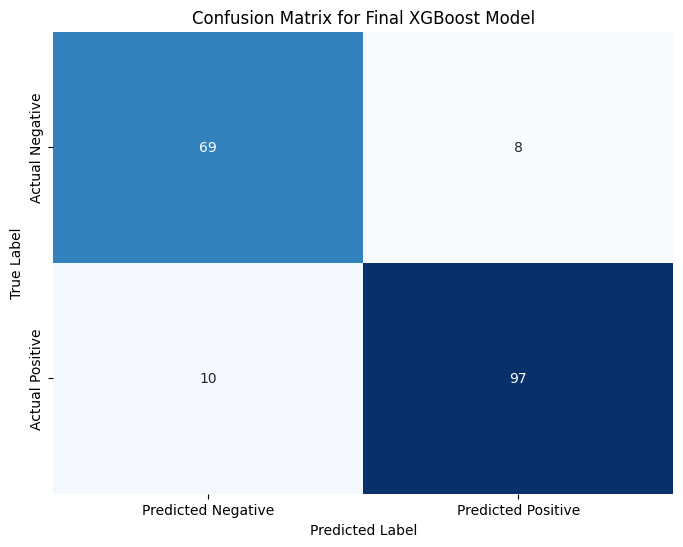

In [172]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(final_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Final XGBoost Model')
plt.show()

Feature Significance (Importance) from XGBoost Model:


Feature,Importance
str,f32
"""ST_Slope_Flat""",0.285315
"""ExerciseAngina_Y""",0.178052
"""ChestPainType_ASY""",0.120025
"""Sex_F""",0.061365
"""ST_Slope_Down""",0.058419
…,…
"""RestingECG_LVH""",0.027753
"""Age""",0.027183
"""ChestPainType_NAP""",0.024554


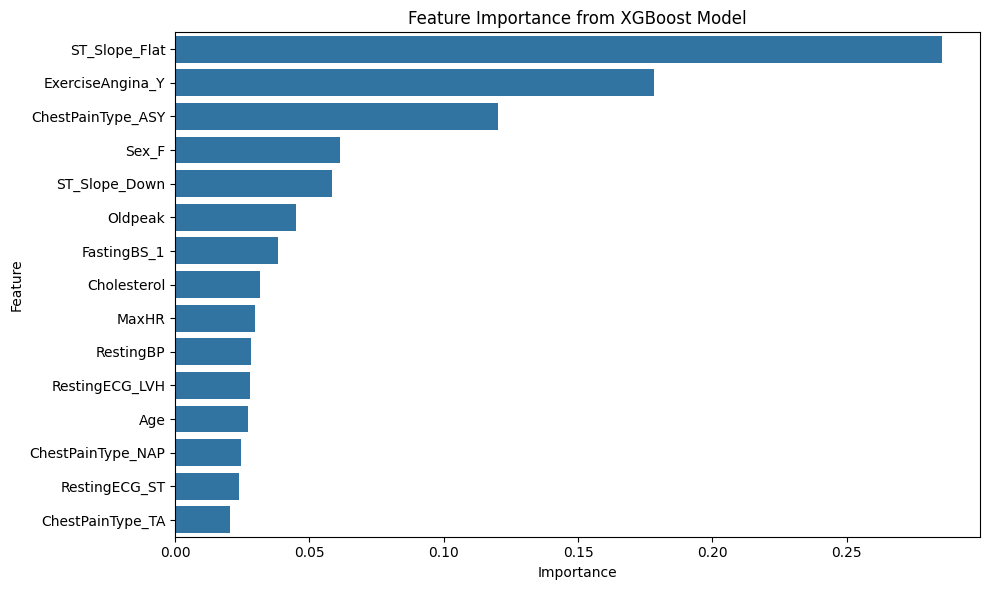

In [174]:
# get feature importances from the trained XGBoost model
feature_importances = final_xgb_model.feature_importances_

# get the feature names from the training data
feature_names = X_train.columns

# create a DataFrame to display feature importance
importance_df = pl.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# sort the DataFrame by importance in descending order
importance_df = importance_df.sort(by='Importance', descending=True)

# Display the feature importance
print("Feature Significance (Importance) from XGBoost Model:")
display(importance_df)

# Optionally, visualize the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.to_pandas()) # Convert to pandas for seaborn plotting
plt.title('Feature Importance from XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [175]:
from pathlib import Path
focus_path = Path("/content/drive/MyDrive/Colab Notebooks/Heart Disease.ipynb")

In [ ]:
!jupyter nbconvert --to html "{focus_path}"